# Package

In [1]:
from google.colab import drive
import pandas as pd
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
data = pd.read_csv('/content/drive/My Drive/data_corr.csv')

In [3]:
# Allows to automatically switch from CPU to GPU
from datetime import timedelta
import itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def is_running_on_gpu():
  if torch.cuda.is_available():
    print("The algorithm is running on GPU.")
  else:
    print("The algorithm is not running on GPU.")

In [4]:
type_float64 = True

if type_float64:
  torch.set_default_dtype(torch.float64)
  np_dtype = np.float64
else:
  torch.set_default_dtype(torch.float32)
  np_dtype = np.float32

## Package PIKL

### PIKL

In [5]:
import time

In [6]:
def normalize(dataset):
    data_min, data_max = np.min(dataset, axis=0), np.max(dataset, axis=0)
    center = (data_min+data_max)/2
    amplitude = data_max-data_min
    amplitude.replace(0, 1, inplace=True)
    return (dataset - center)/amplitude*2*torch.pi

def Sob_elementary(alpha, s, m):
    Sob_elem = torch.cat((torch.arange(-m, 0, device=device), torch.arange(1, m+1, device=device)))
    return alpha*(1+Sob_elem**(2*s))

def Sob_matrix(alpha_list, s_list, m_list):
    d = len(s_list)
    total_length = 1+sum(1 if m == 'Linear' else 2 * m for m in m_list)
    Sob_diag = torch.zeros(total_length, device=device)
    Sob_diag[0] = alpha_list[0]
    idx = 1
    for i in range(d):
        if m_list[i] == 'Linear':
            Sob_diag[idx] = alpha_list[i + 1]
            idx += 1
        else:
            Sob_diag[idx:idx + 2*m_list[i]] = Sob_elementary(alpha_list[i + 1], s_list[i], m_list[i])
            idx += 2*m_list[i]
    return torch.diag(Sob_diag)


def mat_frequency(m_list, n):
    total_length = 1+sum(2 * m if m != "Linear" else 1 for m in m_list)
    frequencies = torch.zeros(total_length, device=device)

    idx = 1
    for m in m_list:
        if m == "Linear":
            idx += 1
        else:
            frequencies[idx:idx + m] = torch.arange(-m, 0, device=device)
            frequencies[idx + m:idx + 2 * m] = torch.arange(1, m + 1, device=device)
            idx += 2 * m
    return torch.tile(frequencies, (n, 1))

def mat_linear(x_data, m_list, n):
    d = len(m_list)
    total_columns = 1+sum(1 if m == 'Linear' else 2 * m for m in m_list)
    mat = torch.zeros(n, total_columns, device=device)
    col_idx = 1
    for i in range(d):
        if m_list[i] == 'Linear':
            mat[:, col_idx] = x_data[:, i] - 1
            col_idx += 1
        else:
            col_idx += 2 * m_list[i]
    return mat

def mat_data(x_data, m_list, n):
    d = len(m_list)
    total_columns = 1+sum(1 if m == 'Linear' else 2 * m for m in m_list)
    mat = torch.zeros(n, total_columns, device=device)

    col_idx = 1
    for i in range(d):
        if m_list[i] == 'Linear':
            mat[:, col_idx] = x_data[:, i]
            col_idx += 1
        else:
            mat[:, col_idx:col_idx + 2 * m_list[i]] = torch.tile(x_data[:, i].view(-1, 1), (1, 2 * m_list[i]))
            col_idx += 2 * m_list[i]
    return mat


def phi_matrix(x_data, m_list):
    n = len(x_data)
    return torch.exp(-1j*torch.mul(mat_data(x_data, m_list, n),mat_frequency(m_list, n))/2)+mat_linear(x_data, m_list, n)

def regression_vector(x_data, y_data, m_list, alpha_list, s_list):
    covariance_matrix_X = torch.conj_physical(torch.transpose(phi_matrix(x_data, m_list), 0,1))@phi_matrix(x_data, m_list)
    covariance_XY = torch.conj_physical(torch.transpose(phi_matrix(x_data, m_list), 0,1))@y_data
    M = Sob_matrix(alpha_list, s_list, m_list)
    return torch.linalg.solve(covariance_matrix_X+len(x_data)*M, covariance_XY)

def estimation(fourier_coefs, z_data, m_list):
    fourier_coefs = fourier_coefs
    return phi_matrix(z_data, m_list)@fourier_coefs


# A améliorer pour envoyer sur GPU
def transform(df, m_list, fourier_vector, features):
    g_h = pd.DataFrame()
    g_h['Load'] = df['Load']
    g_h['Time']=df['Time']
    g_h['PIKL'] = torch.real(estimation(fourier_vector, torch.tensor(df[features].values, device=device), m_list)).view(-1).cpu().numpy()
    g_h["error"]=df["Load"]-g_h['PIKL']
    phi_mat = phi_matrix(torch.tensor(df[features].values, device=device), m_list)

    current = 1
    for j in range(len(features)):
        if m_list[j]=="Linear":
            linear_coeff = fourier_vector[current].cpu()
            g_h[features[j]] = linear_coeff*torch.tensor(df[features[j]].values).view(-1)
            current+= 1
        elif m_list[j] < 1:
            g_h[features[j]] = 0*1j
        else:
            partial_fourier = fourier_vector[current:current+2*m_list[j]]
            g_h[features[j]] = (phi_mat[:, current:current+2*m_list[j]]@partial_fourier).view(-1).cpu()
            current+= 2*m_list[j]
    return g_h



### Grid search PIKL

In [7]:
def calculate_total_length(m_list):
    return 1 + sum(2 * m if m != "Linear" else 1 for m in m_list)

def mat_frequency_h(m_list, n):
    total_length = calculate_total_length(m_list)
    frequencies = torch.zeros(total_length, device=device)

    idx = 1
    for m in m_list:
        if m == "Linear":
            idx += 1
        else:
            freq_range = torch.arange(1, m + 1, device=device)
            frequencies[idx:idx + m] = -freq_range.flip(0)
            frequencies[idx + m:idx + 2 * m] = freq_range
            idx += 2 * m
    return frequencies.unsqueeze(0).unsqueeze(0)

def mat_linear_h(x_data, m_list):
    batch_size, n, d = x_data.shape
    total_columns = calculate_total_length(m_list)
    mat = torch.zeros(batch_size, n, total_columns, device=device)

    col_idx = 1
    for i, m in enumerate(m_list):
        if m == 'Linear':
            mat[:, :, col_idx] = x_data[:, :, i] - 1
            col_idx += 1
        else:
            col_idx += 2 * m
    return mat

def mat_data_h(x_data, m_list):
    batch_size, n, d = x_data.shape
    total_columns = calculate_total_length(m_list)
    mat = torch.zeros(batch_size, n, total_columns, device=device)

    col_idx = 1
    for i, m in enumerate(m_list):
        if m == 'Linear':
            mat[:, :, col_idx] = x_data[:, :, i]
            col_idx += 1
        else:
            repeated_data = x_data[:, :, i].unsqueeze(2).expand(batch_size, n, 2 * m)
            mat[:, :, col_idx:col_idx + 2 * m] = repeated_data
            col_idx += 2 * m
    return mat

def phi_matrix_h(x_data, m_list):
    batch_size = x_data.size(0)
    n = x_data.size(1)
    return torch.exp(-1j * mat_data_h(x_data, m_list) * mat_frequency_h(m_list, n) / 2) + mat_linear_h(x_data, m_list)


In [8]:
def cov_hourly_m(m_list, data_hourly):
    cov_hourly = []
    x_data, x_test, y_data, ground_truth = data_hourly

    phi_mat = phi_matrix_h(x_data, m_list)
    covariance_matrix_X = torch.bmm(phi_mat.transpose(1, 2).conj(), phi_mat)
    covariance_XY = torch.bmm(phi_mat.transpose(1, 2).conj(), y_data)
    phi_mat_z = phi_matrix_h(x_test, m_list)

    return covariance_matrix_X, covariance_XY, phi_mat_z, ground_truth

def regression_vector_grid(covariance_matrix_X, covariance_XY, M):
    return torch.linalg.solve(covariance_matrix_X+M, covariance_XY)

In [9]:
def hour_formatting(data, date, features_pikl):
    begin_train, end_train, end_test = date["begin_train"], date["end_train"], date["end_test"]
    features, features1, features2 = features_pikl["features_union"], features_pikl["features1"], features_pikl["features2"]
    data_hourly = []

    for h in range(24):
        data_h = data[data['Hour']==h]

        data_h.loc[:,features]=normalize(data_h.loc[:,features]).loc[:,features]
        df_train = data_h[(data_h['Time']>= begin_train)&(data_h['Time']<end_train)]
        df_test = data_h[(data_h['Time']>= end_train)&(data_h['Time']<end_test)]

        if h<8:
            x_data = torch.tensor(df_train[features1].values, device=device)
            x_test = torch.tensor(df_test[features1].values, device=device)
        else :
            x_data = torch.tensor(df_train[features2].values, device=device)
            x_test = torch.tensor(df_test[features2].values, device=device)

        y_data = torch.tensor(df_train['Load'].values, device=device).view(-1,1)*(1+0*1j)
        ground_truth = torch.tensor(df_test['Load'].values, device=device)

        if type_float64:
          data_hourly.append([x_data, x_test, y_data, ground_truth])
        else:
          data_hourly.append([x_data.to(torch.float32), x_test.to(torch.float32), y_data.to(torch.complex64), ground_truth.to(torch.float32)])

    x_data = torch.stack([data_hourly[i][0] for i in range(24)])
    x_test = torch.stack([data_hourly[i][1] for i in range(24)])
    y_data = torch.stack([data_hourly[i][2] for i in range(24)])
    ground_truth = torch.stack([data_hourly[i][3] for i in range(24)])
    return x_data, x_test, y_data, ground_truth


In [10]:
def sob_effects(features_pikl, m_list, s_list, n):
    features_type = features_pikl["features_type"]
    n_param = len(features_type)+1
    one_list = [1. for i in range(n_param)]
    select_dim = [[0 for i in range(n_param)] for i in range(n_param)]
    for i in range(n_param):
        select_dim[i][i] = 1
    sobolev_effects = []
    for i in range(n_param):
        sobolev_effects.append(Sob_matrix(select_dim[i], s_list, m_list))
    sobolev_effects = torch.stack(sobolev_effects)*n
    return sobolev_effects

In [11]:
def PIKL(data, hyperparameters, cov_hourly, M_stacked):
    m_list, s_list, alpha_list = hyperparameters["m_list"], hyperparameters["s_list"], hyperparameters["alpha_list"]

    fourier_vectors= torch.linalg.solve(cov_hourly[0]+M_stacked, cov_hourly[1])
    estimators = torch.matmul(cov_hourly[2], fourier_vectors).squeeze(-1)
    mae_houlry = torch.mean(torch.abs(estimators-cov_hourly[3]), dim=1)
    mae = torch.mean(mae_houlry)
    return mae, fourier_vectors, mae_houlry

In [12]:
def create_grid(features_pikl, n, grid_parameters):
    features_type = features_pikl["features_type"]
    grid_size_m, grid_size_p, grid_step_p = grid_parameters["grid_size_m"], grid_parameters["grid_size_p"], grid_parameters["grid_step_p"]
    number_regression = 0

    m_range, alpha_const, alpha_grid_range, s_list = [], [[10**(-30)]], [], [] # Initializing power with the offset
    for feature_type in features_type:
        if feature_type in ["bool", "linear"]:
            m_range.append(["Linear"]), alpha_const.append([10**(-30)]), s_list.append("*")
        elif feature_type[:11] == "categorical":
            n_categories = int(feature_type[11:])
            m_range.append([n_categories//2+n_categories%2]), alpha_const.append([10**(-30)]), s_list.append(0)
        elif feature_type == "regression":
            m_ini = grid_parameters["m_ini"]
            power_ini = -int(np.log(n)/np.log(10))
            m_possibilities = list(range(m_ini-grid_size_m, m_ini+grid_size_m+1))

            power_possibilities = np.arange(power_ini-grid_size_p*grid_step_p, power_ini+(grid_size_p+1)*grid_step_p, grid_step_p)
            m_range.append(m_possibilities), alpha_grid_range.append(10**power_possibilities), s_list.append(2)
            number_regression+=1
    grid_m = list(itertools.product(*m_range))

    grid_a = torch.cartesian_prod(*torch.tensor(np.array(alpha_grid_range, dtype=np_dtype), device=device)).view(-1, number_regression, 1, 1)
    alpha_const = torch.tensor(alpha_const, device=device).view(-1, 1, 1)

    regression_mask = [i+1 for i in range(len(features_type)) if features_type[i] == "regression"]
    non_reg_mask = [0]+[i+1 for i in range(len(features_type)) if features_type[i] != "regression"]
    return grid_m, alpha_const, grid_a, s_list, regression_mask, non_reg_mask


def grid_search_pikl(data, date, features_pikl, n, grid_parameters):
    grid_m, alpha_const, grid_a, s_list, regression_mask, non_reg_mask = create_grid(features_pikl, n, grid_parameters)
    len_grid_m, len_grid_a, counter = len(grid_m), len(grid_a), 0

    grid_a = grid_a.split(grid_parameters["batch_size"], dim=0)

    mae_min = torch.inf
    mae_h=[]
    m_list_opt, power_list_opt, mae_list_opt, fourier_opt = [], [], [], []
    alpha_list_opt = torch.tensor([], device=device)

    data_hourly = hour_formatting(data, date, features_pikl)

    for m_list in grid_m:
      cov_hourly = cov_hourly_m(m_list, data_hourly)

      sobolev_effects = sob_effects(features_pikl, m_list, s_list, len(data_hourly[0][0]))
      mul1 = alpha_const*(sobolev_effects[non_reg_mask,:].unsqueeze(0))

      for grid_a_batch in grid_a:
        mul2 = grid_a_batch*(sobolev_effects[regression_mask,:].unsqueeze(0))
        sobolev_matrices = torch.sum(mul1, dim=1, keepdim=True) + torch.sum(mul2, dim=1, keepdim=True)
        fourier_vectors= torch.linalg.solve(cov_hourly[0].unsqueeze(0)+sobolev_matrices, cov_hourly[1].unsqueeze(0))
        estimators = torch.matmul(cov_hourly[2].unsqueeze(0), fourier_vectors).squeeze(-1)
        errors = torch.abs(cov_hourly[3].unsqueeze(0)-estimators)
        mae_hourly =  torch.mean(errors, dim=2)
        mae_mean = torch.mean(mae_hourly, dim=1)
        min_mae_index = torch.argmin(mae_mean)

        if mae_mean[min_mae_index] < mae_min:
              m_list_opt, alpha_list_opt, mae_opt, fourier_opt, mae_h = m_list, grid_a_batch[min_mae_index], mae_mean[min_mae_index], fourier_vectors[min_mae_index], mae_hourly[min_mae_index]
              mae_min = mae_mean[min_mae_index]
      print(str(counter*len_grid_a)+"/"+str(len_grid_m*len_grid_a))
      counter+=1
    alpha_opt = torch.zeros(len(regression_mask)+len(non_reg_mask), device=device)
    alpha_opt[regression_mask] = alpha_list_opt.view(-1)
    alpha_opt[non_reg_mask] = alpha_const.view(-1)
    return m_list_opt, alpha_opt, s_list, mae_opt, fourier_opt, mae_h


### Significativité des effets

In [13]:
def P_matrix(x_data, m_list, alpha_list, s_list):
    covariance_matrix_X = torch.conj_physical(torch.transpose(phi_matrix(x_data, m_list), 0,1))@phi_matrix(x_data, m_list)
    M = Sob_matrix(alpha_list, s_list, m_list)
    return torch.linalg.solve(covariance_matrix_X+len(x_data)*M, torch.conj_physical(torch.transpose(phi_matrix(x_data, m_list), 0,1)))

def sigma_estimate(x_data, m_list, alpha_list, s_list, fourier_vector, y_data):
    n = len(x_data)
    P = P_matrix(x_data, m_list, alpha_list, s_list)
    tr = torch.real(torch.trace(phi_matrix(x_data, m_list)@P))
    interpolation = torch.real(estimation(fourier_vector, x_data, m_list)).view(-1)
    err = torch.sum(torch.square(torch.abs(interpolation-y_data.view(-1)))).item()
    return 1/(n-tr)*err

def t_test(x_data, m_list, alpha_list, s_list, fourier_vector, y_data):
    t_stat = []
    P = P_matrix(x_data, m_list, alpha_list, s_list)
    mat = P@phi_matrix(x_data, m_list)@ torch.conj_physical(torch.transpose(phi_matrix(x_data, m_list), 0,1))@ torch.conj_physical(torch.transpose(P, 0,1))
    sigma = sigma_estimate(x_data, m_list, alpha_list, s_list, fourier_vector, y_data).item()
    for i in range(len(fourier_vector)):
        t_stat.append(fourier_vector[i].item()/np.sqrt(mat[i,i].item()*sigma))
    return np.array(t_stat)

def print_t_test(test, features, m_list):
    print("--------------------------")
    print("T-tests")
    print("Offset: t-test = "+str(np.abs(test[0])), ", significant (5%) = "+ str(np.abs(test[0]) > 2))
    index = 0
    for i in range(len(features)):
        print('Feature '+ features[i])
        if m_list[i]=='Linear':
            index+=1
            print("Linear coefficient t-test = "+str(np.abs(test[index])), ", significant (5%) = "+ str(np.abs(test[index]) > 2))
        else:
            for j in range(2*m_list[i]):
                index+=1
                print("Fourier coefficient "+str(j)+" t-test = "+str(np.abs(test[index])), ", significant (5%) = "+ str(np.abs(test[index]) > 2))
    print("--------------------------")
    return

In [14]:
def print_effect(data, dates, features_pikl, hyperparameters, fourier_vectors, h):
    m_list, s_list, alpha_list = hyperparameters["m_list"], hyperparameters["s_list"], hyperparameters["alpha_list"]
    begin_train, end_train = dates["begin_train"], dates["end_train"]

    if h<8:
        features = features_pikl["features1"]
    else:
        features = features_pikl["features2"]

    df_h = data[data['Hour'] == h]
    df_h=df_h[features+['Load','Time']]
    df_h.loc[:,features]=normalize(df_h[features]).loc[:,features]
    df_h = df_h[(df_h['Time']>= begin_train)&(df_h['Time']<end_train)]

    x_data = torch.tensor(df_h[features].values, device=device)
    y_data = torch.tensor(df_h['Load'].values, device=device).view(-1,1)*(1+0*1j)
    test=t_test(x_data, m_list, alpha_list, s_list, fourier_vectors[h], y_data)
    print_t_test(test, features, m_list)

    g_h=transform(df_h, m_list, fourier_vectors[h], features)

    for feature in features:
        print(feature)
        plt.figure()
        plt.scatter(df_h[feature], np.real(g_h[feature]))
        plt.show()




## Time-varying PIKL

In [15]:
def calculate_total_length(m_list):
    return 1 + sum(2 * m if m != "Linear" else 1 for m in m_list)

def mat_frequency_online(m_list):
    total_length = calculate_total_length(m_list)
    frequencies = torch.zeros(total_length, device=device)

    idx = 1
    for m in m_list:
        if m == "Linear":
            idx += 1
        else:
            freq_range = torch.arange(1, m + 1, device=device)
            frequencies[idx:idx + m] = -freq_range.flip(0)
            frequencies[idx + m:idx + 2 * m] = freq_range
            idx += 2 * m

    return frequencies.unsqueeze(0).unsqueeze(0).unsqueeze(0)

def mat_linear_online(x_data, m_list):
    batch_size, steps, n, d = x_data.shape
    total_columns = calculate_total_length(m_list)
    mat = torch.zeros(batch_size, steps, n, total_columns, device=device)

    col_idx = 1
    for i, m in enumerate(m_list):
        if m == 'Linear':
            mat[:, :, :, col_idx] = x_data[:, :, :, -1] - 1
            col_idx += 1
        else:
            col_idx += 2 * m
    return mat

def mat_data_online(x_data, m_list):
    batch_size, steps, n, d = x_data.shape
    total_columns = calculate_total_length(m_list)
    mat = torch.zeros(batch_size, steps, n, total_columns, device=device)

    mat[:, :, :, 0] = 1

    col_idx = 1
    for i, m in enumerate(m_list):
        if m == 'Linear':
            mat[:, :, :, col_idx] = x_data[:, :, :, i]
            col_idx += 1
        else:
            repeated_data = x_data[:, :, :, i].unsqueeze(-1).expand(batch_size, steps, n, 2 * m)
            mat[:, :, :, col_idx:col_idx + 2 * m] = repeated_data
            col_idx += 2 * m
    return mat


def mat_time_online(x_data, m_list):
    batch_size, steps, n, d = x_data.shape
    total_columns = calculate_total_length(m_list)
    mat = torch.zeros(batch_size, steps, n, total_columns, device=device)

    col_idx = 1
    for i, m in enumerate(m_list):
        if m == 'Linear':
            mat[:, :, :, col_idx] = x_data[:, :, :, -1]
            col_idx += 1
        else:
            repeated_data = x_data[:, :, :, -1].unsqueeze(-1).expand(batch_size, steps, n, 2 * m)
            mat[:, :, :, col_idx:col_idx + 2 * m] = repeated_data
            col_idx += 2 * m
    return mat

def phi_matrix_online(x_data, m_list):
    return  mat_data_online(x_data, m_list) *(torch.exp(-1j * mat_time_online(x_data, m_list)* mat_frequency_online(m_list) / 2) + mat_linear_online(x_data, m_list))


In [16]:
def cov_hourly_online(m_list, data_hourly):
    cov_hourly = []
    x_data, x_test, y_data, ground_truth = data_hourly

    phi_mat = phi_matrix_online(x_data, m_list)
    covariance_matrix_X = torch.matmul(phi_mat.transpose(2, 3).conj(), phi_mat)
    covariance_XY = torch.matmul(phi_mat.transpose(2, 3).conj(), y_data)
    phi_mat_z = phi_matrix_online(x_test, m_list)

    return covariance_matrix_X, covariance_XY, phi_mat_z, ground_truth

In [17]:
def hour_formatting_online(data, date, features_pikl, hyperparameters):
    begin_train, end_train, end_test = date["begin_train"], date["end_train"], date["end_test"]
    features, features1, features2 = features_pikl["features_union"], features_pikl["features1"], features_pikl["features2"]
    fourier_vectors = hyperparameters["fourier_vectors"]
    m_list = hyperparameters["m_list"]
    window = hyperparameters["window"]
    data_hourly = []

    for h in range(24):
        x_online_list, x_test_list, y_online_list=[],[],[]

        data_h = data[data['Hour']==h]

        data_h.loc[:,features]=normalize(data_h.loc[:,features]).loc[:,features]

        if h<8:
            g_h=transform(data_h, m_list, fourier_vectors[h], features1)
            g_h.loc[:,features1]=normalize(g_h.loc[:,features1]).loc[:,features1]

        else:
            g_h=transform(data_h, m_list, fourier_vectors[h], features2)
            g_h.loc[:,features2]=normalize(g_h.loc[:,features2]).loc[:,features2]

        current_end_train = pd.to_datetime(end_train)
        current_end_test = current_end_train+timedelta(days=window)
        g_h['Time']=pd.to_datetime(g_h['Time'])

        learning_window = len(g_h[(g_h['Time']>=begin_train)&(g_h['Time']<current_end_train)])

        while current_end_train < pd.to_datetime(end_test):
            g_train = g_h[(g_h['Time']>=begin_train)&(g_h['Time']<current_end_train)]
            g_test = g_h[(g_h['Time']>=current_end_train)&(g_h['Time']<current_end_test)]
            if h<8:
                x_online = torch.tensor(g_train[features1].values, device=device)
                x_test_online = torch.tensor(g_test[features1].values, device=device)
            else:
                x_online = torch.tensor(g_train[features2].values, device=device)
                x_test_online = torch.tensor(g_test[features2].values, device=device)

            if x_test_online.shape[0] != 0:
                y_online = torch.tensor(g_train['error'].values, device=device).view(-1,1)*(1+0*1j)

                if not type_float64:
                    x_online, x_test_online, y_online = x_online.to(torch.float32), x_test_online.to(torch.float32), y_online.to(torch.complex64)
                x_online_list.append(x_online[-learning_window:,:])
                x_test_list.append(x_test_online)
                y_online_list.append(y_online[-learning_window:,:])


            current_end_train = current_end_train+timedelta(days=window)
            current_end_test = min(current_end_test+timedelta(days=window), pd.to_datetime(end_test))

        g_test = g_h[(g_h['Time']>=end_train)&(g_h['Time']<end_test)]
        ground_truth_online = torch.tensor(g_test['error'].values, device=device)

        if not type_float64:
              ground_truth_online = ground_truth_online.to(torch.float32)
        data_hourly.append([torch.stack(x_online_list), torch.stack(x_test_list), torch.stack(y_online_list), ground_truth_online])

    x_data = torch.stack([data_hourly[i][0] for i in range(24)])
    x_test = torch.stack([data_hourly[i][1] for i in range(24)])
    y_data = torch.stack([data_hourly[i][2] for i in range(24)])
    ground_truth = torch.stack([data_hourly[i][3] for i in range(24)])

    return x_data, x_test, y_data, ground_truth

In [18]:
def grid_search_online(data, date, features_pikl, n, grid_parameters, hyperparameters):
    grid_m, alpha_const, grid_a, s_list, regression_mask, non_reg_mask = create_grid(features_pikl, n, grid_parameters)
    len_grid_m, len_grid_a, counter = len(grid_m), len(grid_a), 0

    grid_a = grid_a.split(grid_parameters["batch_size"], dim=0)

    mae_min = torch.inf
    mae_h=[]
    m_list_opt, power_list_opt, mae_list_opt, fourier_opt = [], [], [], []
    alpha_list_opt = torch.tensor([], device=device)

    data_hourly = hour_formatting_online(data, date, features_pikl, hyperparameters)

    for m_list in grid_m:
      cov_hourly = cov_hourly_online(m_list, data_hourly)


      sobolev_effects = sob_effects(features_pikl, m_list, s_list, len(data_hourly[0][0][0]))
      mul1 = alpha_const*(sobolev_effects[non_reg_mask,:].unsqueeze(0))

      for grid_a_batch in grid_a:
        mul2 = grid_a_batch*(sobolev_effects[regression_mask,:].unsqueeze(0))
        sobolev_matrices = torch.sum(mul1, dim=1, keepdim=True) + torch.sum(mul2, dim=1, keepdim=True)
        sobolev_matrices = sobolev_matrices.unsqueeze(2)

        fourier_vectors= torch.linalg.solve(cov_hourly[0].unsqueeze(0)+sobolev_matrices, cov_hourly[1].unsqueeze(0))
        estimators = torch.matmul(cov_hourly[2].unsqueeze(0), fourier_vectors).squeeze(-1)
        errors = torch.abs(cov_hourly[3].unsqueeze(0)-estimators.squeeze(-1))
        mae_hourly =  torch.mean(errors, dim=2)
        mae_mean = torch.mean(mae_hourly, dim=1)
        min_mae_index = torch.argmin(mae_mean)

        if mae_mean[min_mae_index] < mae_min:
              m_list_opt, alpha_list_opt, mae_opt, fourier_opt, mae_h = m_list, grid_a_batch[min_mae_index], mae_mean[min_mae_index], fourier_vectors[min_mae_index], mae_hourly[min_mae_index]
              mae_min = mae_mean[min_mae_index]
      print(str(counter*len_grid_a)+"/"+str(len_grid_m*len_grid_a))
      counter+=1
    alpha_opt = torch.zeros(len(regression_mask)+len(non_reg_mask), device=device)
    alpha_opt[regression_mask] = alpha_list_opt.view(-1)
    alpha_opt[non_reg_mask] = alpha_const.view(-1)
    return m_list_opt, alpha_opt, s_list, mae_opt, fourier_opt, mae_h


## Test

Phi_matrix = tensor([[ 1.0000+0.j, -3.0788+0.j],
        [ 1.0000+0.j, -3.0159+0.j],
        [ 1.0000+0.j, -2.9531+0.j],
        [ 1.0000+0.j, -2.8903+0.j],
        [ 1.0000+0.j, -2.8274+0.j],
        [ 1.0000+0.j, -2.7646+0.j],
        [ 1.0000+0.j, -2.7018+0.j],
        [ 1.0000+0.j, -2.6389+0.j],
        [ 1.0000+0.j, -2.5761+0.j]], device='cuda:0')
Coeff reg = tensor([[-6.4797e-07+0.j],
        [ 1.5915e+01+0.j]], device='cuda:0')
std = 7.522810081428978e-06
t_tests=[-8.61345117e-02+0.j  2.11563131e+06+0.j]
Comme attendu, t_test[0] petit car l'offset est nul, et t_test[1] est grand car c'est bien linéaire.
--------------------------
T-tests
Offset: t-test = 0.0861345116504856 , significant (5%) = False
Feature X1
Linear coefficient t-test = 2115631.3066223045 , significant (5%) = True
--------------------------


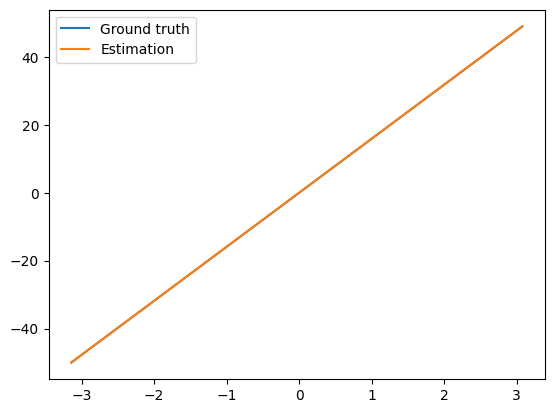

In [20]:
n=100
x_data = torch.tensor([[np.pi*(2*i/n-1)] for i in range(n)], device=device)
y_data = torch.tensor([(i-n/2) for i in range(n)], device=device).view(-1,1)*(1+0*1j)
m_list = ['Linear']
features = ["X1"]
alpha_list = [10**-30,10**-10]
s_list = [1]
fourier_vector = regression_vector(x_data, y_data, m_list, alpha_list, s_list)
test=t_test(x_data, m_list, alpha_list, s_list, fourier_vector, y_data)

plt.figure()
plt.plot(x_data.view(-1).cpu(), torch.real(y_data.view(-1)).cpu(), label="Ground truth")
plt.plot(x_data.view(-1).cpu(), torch.real(estimation(fourier_vector, x_data, m_list)).view(-1).cpu(), label="Estimation")
plt.legend()
plt.plot()
print("Phi_matrix = "+str(phi_matrix(x_data, m_list)[1:10,:]))
print("Coeff reg = "+str(fourier_vector))
print("std = "+str(np.sqrt(sigma_estimate(x_data, m_list, alpha_list, s_list, fourier_vector, y_data).item())))
print("t_tests="+str(test))
print("Comme attendu, t_test[0] petit car l'offset est nul, et t_test[1] est grand car c'est bien linéaire.")
print_t_test(test, features, m_list)

Phi_matrix = tensor([[1.0000+0.0000j, 0.0314-0.9995j, 0.0314+0.9995j],
        [1.0000+0.0000j, 0.0628-0.9980j, 0.0628+0.9980j],
        [1.0000+0.0000j, 0.0941-0.9956j, 0.0941+0.9956j],
        [1.0000+0.0000j, 0.1253-0.9921j, 0.1253+0.9921j],
        [1.0000+0.0000j, 0.1564-0.9877j, 0.1564+0.9877j],
        [1.0000+0.0000j, 0.1874-0.9823j, 0.1874+0.9823j],
        [1.0000+0.0000j, 0.2181-0.9759j, 0.2181+0.9759j],
        [1.0000+0.0000j, 0.2487-0.9686j, 0.2487+0.9686j],
        [1.0000+0.0000j, 0.2790-0.9603j, 0.2790+0.9603j]], device='cuda:0')
Coeff reg = tensor([[ 2372.6865+1.6056e-06j],
        [-1208.9937+1.2732e+00j],
        [-1208.9935-1.2732e+00j]], device='cuda:0')
std = 42.536377182231476
t_tests=[ 55.78017573+3.77204588e-08j -28.42436909+2.99306801e-02j
 -28.42436283-2.99291896e-02j]
--------------------------
T-tests
Offset: t-test = 55.78017573015606 , significant (5%) = True
Feature X1
Fourier coefficient 0 t-test = 28.4243848450715 , significant (5%) = True
Fourier coe

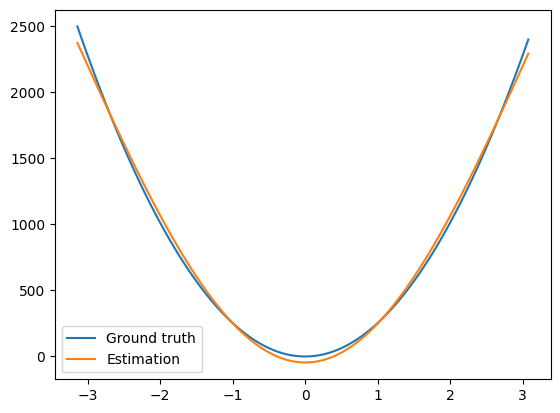

In [21]:
n=100
x_data = torch.tensor([[np.pi*(2*i/n-1)] for i in range(n)], device = device)
y_data = torch.tensor([(i-n/2)**2 for i in range(n)], device=device).view(-1,1)*(1+0*1j)
m_list = [1]
features = ["X1"]
alpha_list = [10**-30,10**-5]
s_list = [1]
fourier_vector = regression_vector(x_data, y_data, m_list, alpha_list, s_list)
test=t_test(x_data, m_list, alpha_list, s_list, fourier_vector, y_data)

plt.figure()
plt.plot(x_data.view(-1).cpu(), torch.real(y_data.view(-1)).cpu(), label="Ground truth")
plt.plot(x_data.view(-1).cpu(), torch.real(estimation(fourier_vector, x_data, m_list)).view(-1).cpu(), label="Estimation")
plt.legend()
plt.plot()
print("Phi_matrix = "+str(phi_matrix(x_data, m_list)[1:10,:]))
print("Coeff reg = "+str(fourier_vector))
print("std = "+str(np.sqrt(sigma_estimate(x_data, m_list, alpha_list, s_list, fourier_vector, y_data).item())))
print("t_tests="+str(test))
print_t_test(test, features, m_list)

# Test Compet Inde

In [19]:
#data = pd.read_csv('data_corr.csv')
data['DayType']=np.float64(data.loc[:,'DayType'])
data['BH']=np.float64(data.loc[:,'BH'])
n = len(data['Time'])
data['time'] = [i/n*np.pi for i in range(n)]

## PIKL

### Validation

In [20]:
dates_val = {"begin_train": "2017-03-18 00:00:00",
"end_train": "2020-01-01 00:00:00",
"end_test": "2020-03-01 00:00:00"}

features_pikl = {"features1": ['DayType','FTemps95_corr1','Load1D','Load1W', 'Toy', 'time'],
"features2": ['DayType','FTemps95_corr1','Load2D','Load1W', 'Toy', 'time'],
"features_type": ["categorical7", "linear", "regression", "regression", "regression", "linear"]}

features_pikl["features_union"] =  np.union1d(features_pikl["features1"],features_pikl["features2"])


In [24]:
grid_parameters ={
    "grid_size_m": 2,
    "m_ini": 5,
    "grid_size_p": 10,
    "grid_step_p": 0.25,
    "batch_size": 5*10**3
} #La procédure est plus lente en m qu'en p. On peut prendre grid_size_p grand mais pas grid_size_m

n = len(data[(data['Time']>= dates_val["begin_train"])&(data['Time']<dates_val["end_train"])])//24

m_list, alpha_list, s_list, mae, fourier_vectors, mae_h = grid_search_pikl(data, dates_val, features_pikl, n, grid_parameters)

hyperparameters = {"m_list": m_list,
                   "s_list": s_list,
                   "alpha_list": alpha_list,
                   "fourier_vectors": fourier_vectors}

print(hyperparameters["m_list"])
print(hyperparameters["alpha_list"])
print(hyperparameters["s_list"])

0/1157625
9261/1157625
18522/1157625
27783/1157625
37044/1157625
46305/1157625
55566/1157625
64827/1157625
74088/1157625
83349/1157625
92610/1157625
101871/1157625
111132/1157625
120393/1157625
129654/1157625
138915/1157625
148176/1157625
157437/1157625
166698/1157625
175959/1157625
185220/1157625
194481/1157625
203742/1157625
213003/1157625
222264/1157625
231525/1157625
240786/1157625
250047/1157625
259308/1157625
268569/1157625
277830/1157625
287091/1157625
296352/1157625
305613/1157625
314874/1157625
324135/1157625
333396/1157625
342657/1157625
351918/1157625
361179/1157625
370440/1157625
379701/1157625
388962/1157625
398223/1157625
407484/1157625
416745/1157625
426006/1157625
435267/1157625
444528/1157625
453789/1157625
463050/1157625
472311/1157625
481572/1157625
490833/1157625
500094/1157625
509355/1157625
518616/1157625
527877/1157625
537138/1157625
546399/1157625
555660/1157625
564921/1157625
574182/1157625
583443/1157625
592704/1157625
601965/1157625
611226/1157625
620487/1157

--------------------------
T-tests
Offset: t-test = 6.531169386322559 , significant (5%) = True
Feature DayType
Fourier coefficient 0 t-test = 0.18124608167869766 , significant (5%) = False
Fourier coefficient 1 t-test = 0.3876976142188658 , significant (5%) = False
Fourier coefficient 2 t-test = 2.347918842411146 , significant (5%) = True
Fourier coefficient 3 t-test = 4.87277302046003 , significant (5%) = True
Fourier coefficient 4 t-test = 4.824724483953076 , significant (5%) = True
Fourier coefficient 5 t-test = 2.1501834683403525 , significant (5%) = True
Fourier coefficient 6 t-test = 0.3236327305361869 , significant (5%) = False
Fourier coefficient 7 t-test = 0.16700608146727094 , significant (5%) = False
Feature FTemps95_corr1
Linear coefficient t-test = 0.41469398748285047 , significant (5%) = False
Feature Load2D
Fourier coefficient 0 t-test = 0.050149946998899936 , significant (5%) = False
Fourier coefficient 1 t-test = 0.04300408256188484 , significant (5%) = False
Fourier 

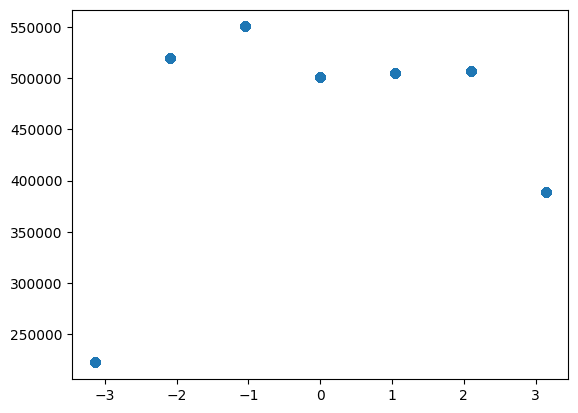

FTemps95_corr1


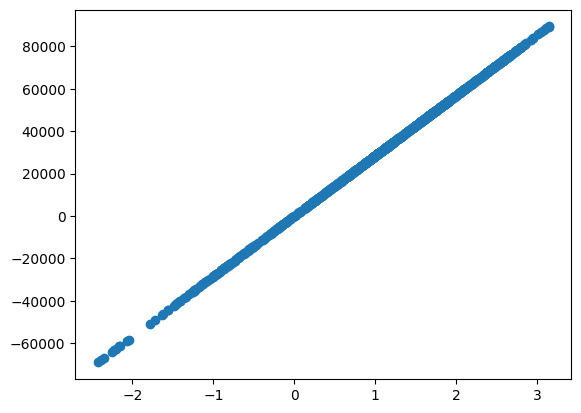

Load2D


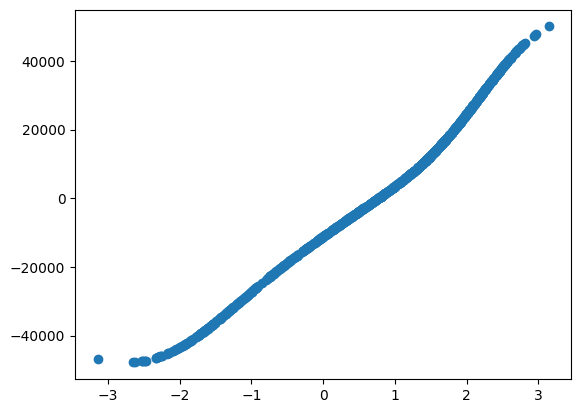

Load1W


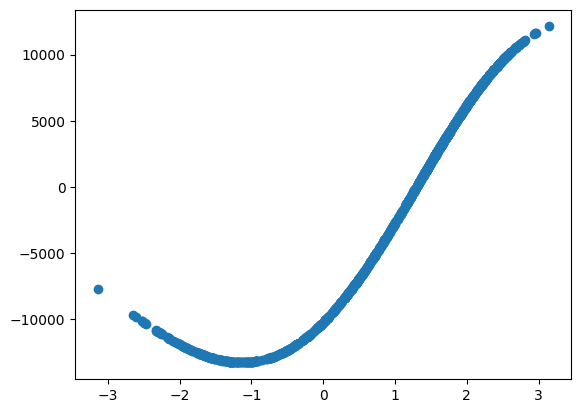

Toy


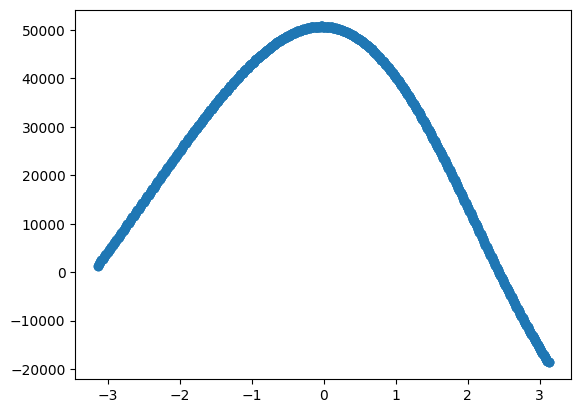

time


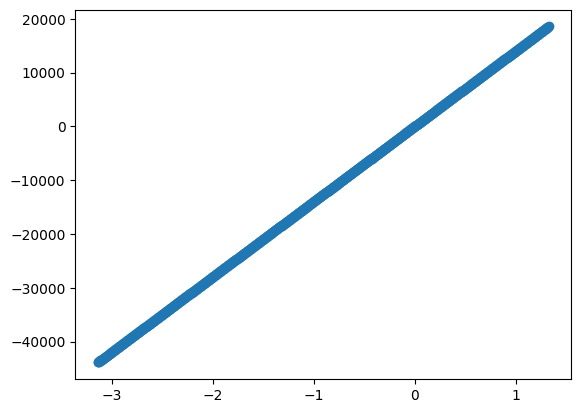

In [25]:
print_effect(data, dates_val, features_pikl, hyperparameters, fourier_vectors, 10)

The mean MAE offline is 18659.428254996503


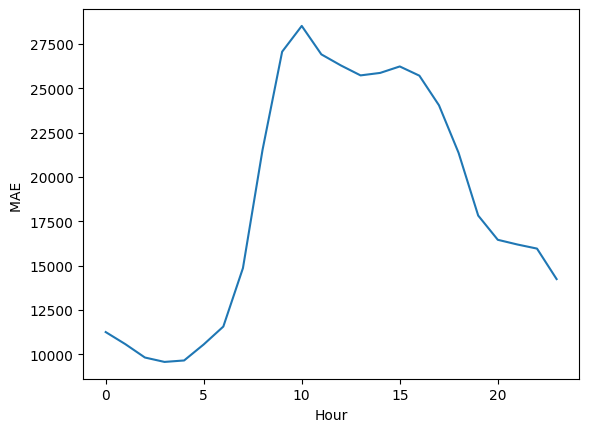

In [26]:
print("The mean MAE offline is "+str(mae.cpu().numpy()))

plt.figure()
plt.plot(np.array([i for i in range(24)]), np.array(mae_h.cpu()))
plt.xlabel("Hour")
plt.ylabel("MAE ")
plt.show()

### Test

In [27]:
dates_test = {"begin_train": "2017-03-18",
"end_train": "2021-01-18",
"end_test": "2021-02-17 00:00:00"}

dates_test = {"begin_train": "2017-03-18",
"end_train": "2020-03-01",
"end_test": "2021-02-17 00:00:00"}

In [28]:
data_hourly = hour_formatting(data, dates_test, features_pikl)
cov_hourly = cov_hourly_m(m_list, data_hourly)
sobolev_matrix = Sob_matrix(alpha_list, s_list, m_list)*len(data_hourly[0][0])
M_stacked = torch.stack([sobolev_matrix for i in range(24)])
mae_test, fourier_vectors_test, mae_h_test = PIKL(data, hyperparameters, cov_hourly, M_stacked)

In [29]:
hyperparameters_test = {"m_list": m_list,
                   "s_list": s_list,
                   "alpha_list": alpha_list,
                   "fourier_vectors": fourier_vectors_test}

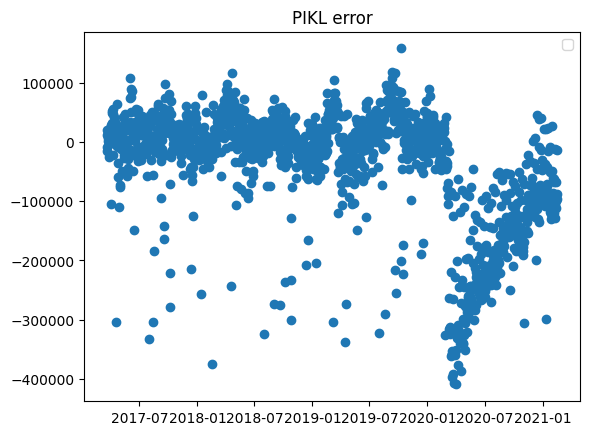

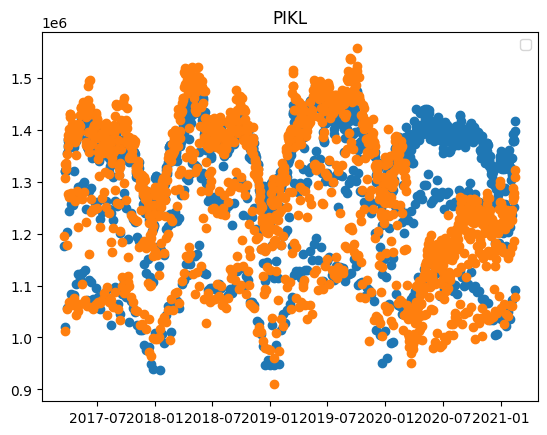

In [30]:
h=10
data_h = data[data['Hour']==h]
data_h.loc[:,features_pikl["features2"]]=normalize(data_h.loc[:,features_pikl["features2"]]).loc[:,features_pikl["features2"]]
estimate = transform(data_h, m_list, fourier_vectors_test[h], features_pikl["features2"])

plt.figure()
plt.title("PIKL error")
plt.scatter(pd.to_datetime(estimate["Time"]), estimate["error"])
plt.legend()
plt.show()

plt.figure()
plt.title("PIKL")
plt.scatter(pd.to_datetime(estimate["Time"]), estimate["PIKL"])
plt.scatter(pd.to_datetime(estimate["Time"]), estimate["Load"])
plt.legend()
plt.show()

The mean MAE offline is 100551.9931857035


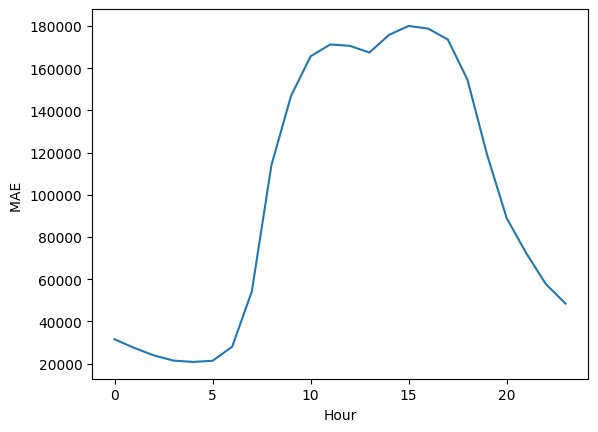

In [31]:
print("The mean MAE offline is "+str(mae_test.cpu().numpy()))

plt.figure()
plt.plot(np.array([i for i in range(24)]), np.array(mae_h_test.cpu()))
plt.xlabel("Hour")
plt.ylabel("MAE ")
plt.show()

## Time-varying PIKL

### Validation

Time must be the last features of the PIKL for the time-varying PIKL to work.

In [52]:
hyperparameters["window"] = 1
dates_val_online = {"begin_train": "2020-03-01 00:00:00",
"end_train": "2020-12-18 00:00:00",
"end_test": "2021-01-18 00:00:00"}

n = len(data[(data['Time']>= dates_val_online["begin_train"])&(data['Time']<dates_val_online["end_train"])])//24
features_pikl["features_type"] = ["regression" for i in range(6)]

grid_parameters ={
    "grid_size_m": 0,
    "m_ini": 3,
    "grid_size_p": 2,
    "grid_step_p": 1.,
    "batch_size": 10**2
}

print(dates_val_online)

{'begin_train': '2020-03-01 00:00:00', 'end_train': '2020-12-18 00:00:00', 'end_test': '2021-01-18 00:00:00'}


In [53]:
m_online, alpha_online, s_online, mae_online_val, fourier_online_val, mae_list_opt = grid_search_online(data, dates_val_online, features_pikl, n, grid_parameters, hyperparameters)

0/15625


(3, 3, 3, 3, 3, 3)
tensor([1.0000e-30, 1.0000e+00, 1.0000e-03, 1.0000e+00, 1.0000e-02, 1.0000e-04,
        1.0000e-02], device='cuda:0')
[2, 2, 2, 2, 2, 2]
15465.595396606603


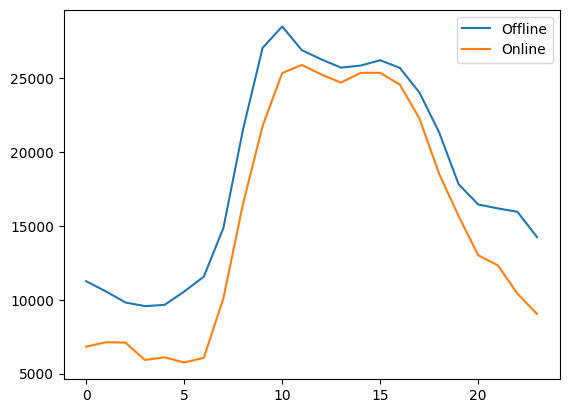

In [54]:
print(m_online)
print(alpha_online)
print(s_online)
print(mae_online_val.cpu().numpy())
plt.plot(np.array([i for i in range(24)]), mae_h.cpu().numpy(), label="Offline")
plt.plot(range(0,24), mae_list_opt.cpu().numpy(), label="Online")
plt.legend()

### Test

In [55]:
dates_test_online = {"begin_train": "2020-03-01 00:00:00",
"end_train": "2021-01-18",
"end_test": "2021-02-17 00:00:00"}

hyperparameters_test["window"] = 1

data_hourly = hour_formatting_online(data, dates_test_online, features_pikl, hyperparameters_test)
cov_hourly = cov_hourly_online(m_online, data_hourly)

sobolev_effects = sob_effects(features_pikl, m_online, s_online, len(data_hourly[0][0][0]))
sobolev_effects_online = (sobolev_effects*alpha_online.unsqueeze(-1).unsqueeze(-1)).sum(dim=0)

fourier_online_test= torch.linalg.solve(cov_hourly[0].unsqueeze(0)+sobolev_effects_online, cov_hourly[1].unsqueeze(0))
estimators = torch.matmul(cov_hourly[2].unsqueeze(0), fourier_online_test).squeeze(-1)
errors = torch.abs(cov_hourly[3].unsqueeze(0)-estimators.squeeze(-1))

In [56]:
mae_online =  torch.mean(errors.squeeze(0), dim=1)
mae_mean = torch.mean(mae_online, dim=0)

The mean MAE online is 11107.611564241766
100551.9931857035


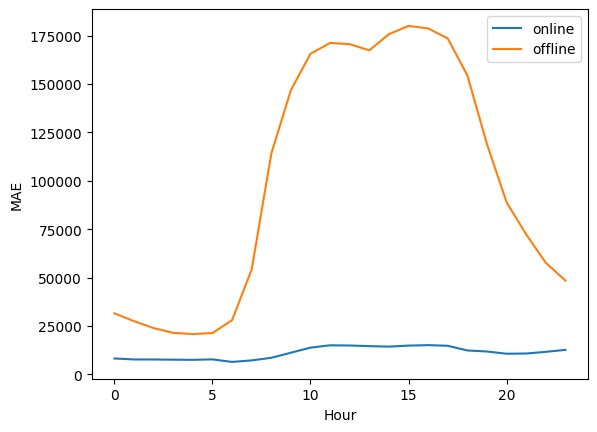

In [57]:
print("The mean MAE online is "+str(mae_mean.cpu().numpy()))
print(mae_test.cpu().numpy())

plt.figure()
plt.plot(np.array([i for i in range(24)]), mae_online.cpu().numpy(), label="online")
plt.plot(np.array([i for i in range(24)]), mae_h_test.cpu(), label="offline")
plt.xlabel("Hour")
plt.ylabel("MAE")
plt.legend()
plt.show()